In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import heapq
import cv2
import os
import kagglehub

In [2]:
def dct2(block):
    return cv2.dct(np.float32(block))

def idct2(block):
    return cv2.idct(np.float32(block))

In [3]:
class Node:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(freqs):
    heap = [Node(sym, f) for sym, f in freqs.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        n1 = heapq.heappop(heap)
        n2 = heapq.heappop(heap)
        merged = Node(None, n1.freq + n2.freq)
        merged.left, merged.right = n1, n2
        heapq.heappush(heap, merged)
    return heap[0]

def make_codes(node, prefix="", codebook={}):
    if node is None:
        return
    if node.symbol is not None:
        codebook[node.symbol] = prefix
    make_codes(node.left, prefix + "0", codebook)
    make_codes(node.right, prefix + "1", codebook)
    return codebook

def huffman_encode(data):
    freqs = Counter(data)
    tree = build_huffman_tree(freqs)
    codes = make_codes(tree, "", {})
    encoded = "".join([codes[val] for val in data])
    return encoded, codes

In [4]:
def compress_image(img_path):
    # Read original image
    img = cv2.imread(img_path)
    # Convert BGR → YCrCb
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    Y, Cr, Cb = cv2.split(ycrcb)
    # Apply DCT on Y channel
    Y_shifted = np.float32(Y) - 128
    dct_Y = dct2(Y_shifted)
    # Quantization
    Q = np.ones_like(dct_Y) * 20
    quantized = np.round(dct_Y / Q)
    # Huffman encoding
    flat = quantized.flatten().astype(int).tolist()
    encoded, codes = huffman_encode(flat)
    comp_size = len(encoded) / 8  # bits → bytes
    # Reconstruct Y channel
    dequantized = quantized * Q
    rec_Y = idct2(dequantized) + 128
    rec_Y = np.clip(rec_Y, 0, 255).astype(np.uint8)
    # Merge reconstructed Y with original Cr, Cb
    rec_img_ycrcb = cv2.merge([rec_Y, Cr, Cb])
    rec_img = cv2.cvtColor(rec_img_ycrcb, cv2.COLOR_YCrCb2BGR)
    # Compression ratio
    orig_size = Y.size
    ratio = orig_size / comp_size
    return ratio, rec_img, orig_size, comp_size

In [5]:
def build_huffman_tree(freqs):
    heap = [Node(sym, f) for sym, f in freqs.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        n1 = heapq.heappop(heap)
        n2 = heapq.heappop(heap)
        merged = Node(None, n1.freq + n2.freq)
        merged.left, merged.right = n1, n2
        heapq.heappush(heap, merged)
    return heap[0]

In [6]:
import kagglehub
path = kagglehub.dataset_download("pavansanagapati/images-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'images-dataset' dataset.
Path to dataset files: /kaggle/input/images-dataset


In [7]:
def display_dataset_results(dataset_path, start_index=0, end_index=10):
    all_images = []
    # Collect all image file paths
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith((".jpg", ".png", ".jpeg")):
                all_images.append(os.path.join(root, file))
    all_images.sort()  # Ensure consistent order
    total = len(all_images)
    print(f"Total images found: {total}")
    # Clip range to dataset size
    start_index = max(0, start_index)
    end_index = min(end_index, total)
    if start_index >= end_index:
        print("⚠️ Invalid range. No images to display.")
        return
    print(f"Displaying images from {start_index} to {end_index - 1}...\n")
    for idx in range(start_index, end_index):
        img_path = all_images[idx]
        file = os.path.basename(img_path)
        try:
            # Read and resize
            orig = cv2.imread(img_path)
            orig = cv2.resize(orig, (256, 256))
            # Convert to YCbCr
            ycbcr_img = cv2.cvtColor(orig, cv2.COLOR_BGR2YCrCb)
            # Call your compression function
            ratio, recon_bgr, orig_size, comp_size = compress_image(img_path)
            # Resize reconstructed image for display consistency
            recon_bgr = cv2.resize(recon_bgr, (256, 256))
            # Print details
            print(f"Original size (bytes): {orig_size}")
            print(f"Compressed size (bytes): {comp_size:.2f}")
            print(f"Compression Ratio: {ratio:.2f}")
            # Display results
            plt.figure(figsize=(12, 4))
            plt.suptitle(f"{file}\nOriginal: {orig_size / 1024:.2f} KB | Compressed: {comp_size / 1024:.2f} KB")
            plt.subplot(1, 3, 1)
            plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
            plt.title("Original")
            plt.axis("off")
            plt.subplot(1, 3, 2)
            plt.imshow(cv2.cvtColor(ycbcr_img, cv2.COLOR_YCrCb2RGB))
            plt.title("YCbCr")
            plt.axis("off")
            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(recon_bgr, cv2.COLOR_BGR2RGB))
            plt.title("Compressed")
            plt.axis("off")
            plt.show()
        except Exception as e:
            print(f"Error processing {file}: {e}")

Total images found: 2036
Displaying images from 21 to 29...

Original size (bytes): 187000
Compressed size (bytes): 25789.88
Compression Ratio: 7.25


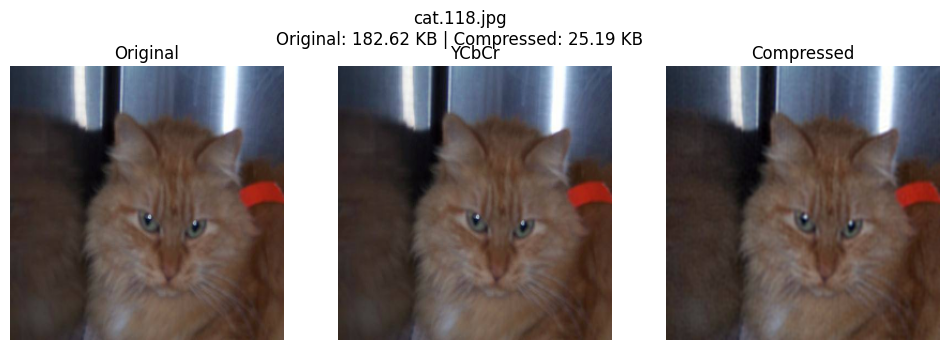

Original size (bytes): 125870
Compressed size (bytes): 29568.62
Compression Ratio: 4.26


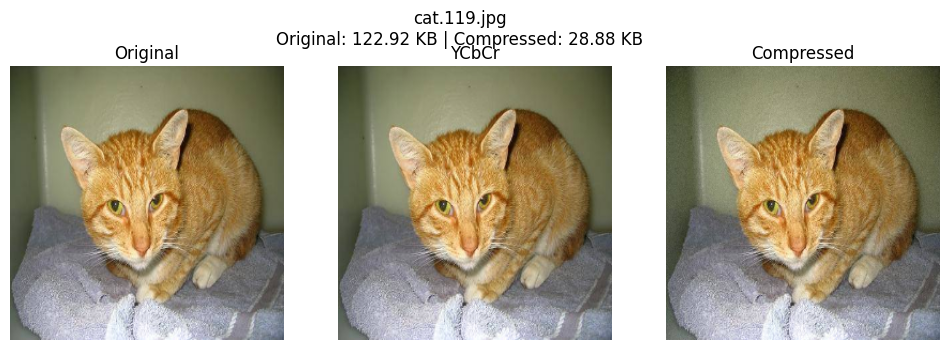

Original size (bytes): 67200
Compressed size (bytes): 13964.50
Compression Ratio: 4.81


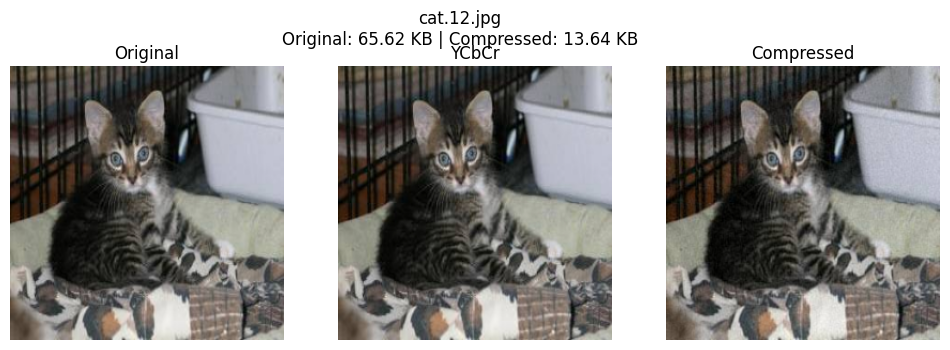

Original size (bytes): 187000
Compressed size (bytes): 33011.00
Compression Ratio: 5.66


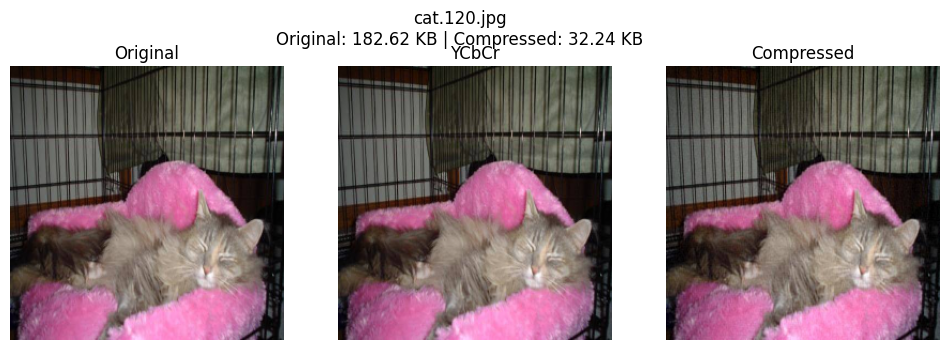

Original size (bytes): 109203
Compressed size (bytes): 21050.00
Compression Ratio: 5.19


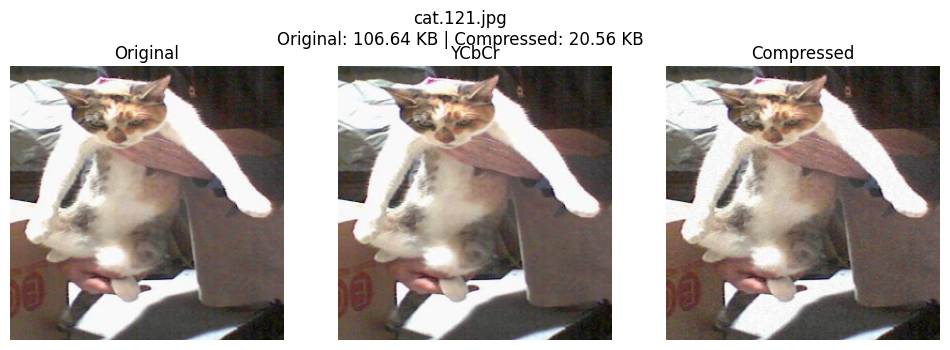

Original size (bytes): 185628
Compressed size (bytes): 29775.00
Compression Ratio: 6.23


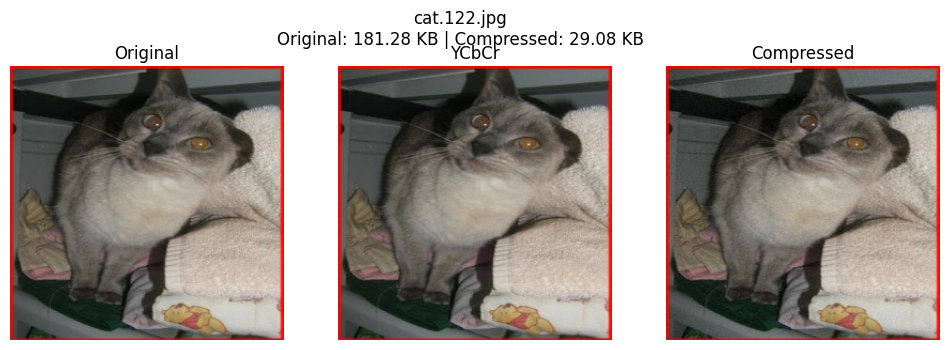

Original size (bytes): 93840
Compressed size (bytes): 14022.88
Compression Ratio: 6.69


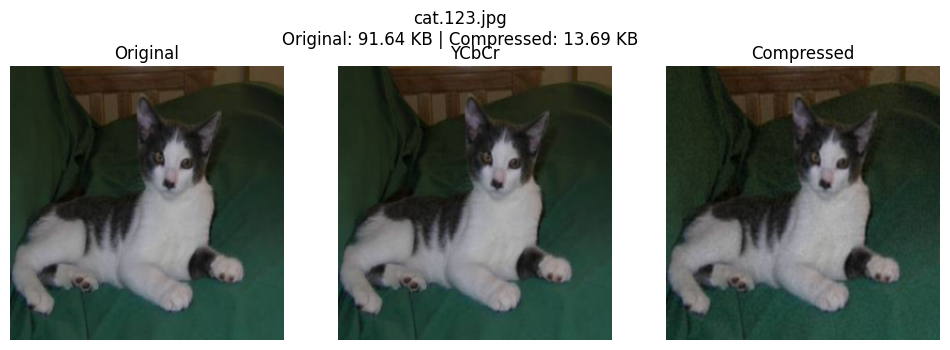

Original size (bytes): 187125
Compressed size (bytes): 29045.88
Compression Ratio: 6.44


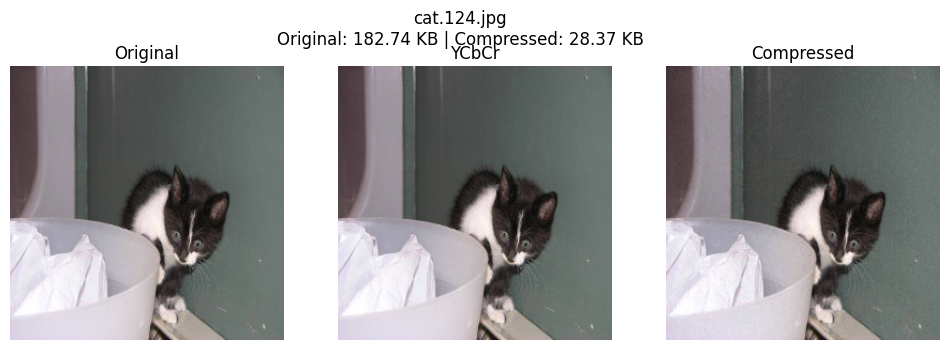

Original size (bytes): 239520
Compressed size (bytes): 35107.88
Compression Ratio: 6.82


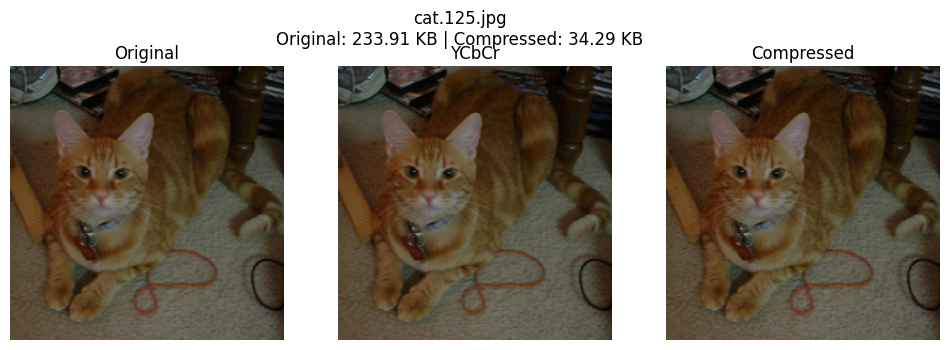

In [11]:
# ---------- Main workflow ----------
dataset_path = path
# Example: show images 10–20
display_dataset_results(dataset_path, start_index=21, end_index=30)